In [48]:
#!/usr/bin/env python
# coding: utf-8

#/sdf/group/lcls/ds/tools/conda_envs/dream/config/dream/alg.yaml
import argparse
import sys
import yaml


import psana as ps
import numpy as np

from scipy.signal import find_peaks

import matplotlib.pyplot as plt 
from matplotlib import colors
plt.style.use('bmh')


from psana.hexanode.PyCFD import PyCFD


sys.path.append('/sdf/group/lcls/ds/tools/smalldata_tools/pedplot/summaries/')
import panel as pn
from summary_utils import prepareHtmlReport

parser = argparse.ArgumentParser(description='Preprocessing Tabulation Application')
parser.add_argument('-r', '--run', type=int, required=True, help='Run number')
parser.add_argument('-e', '--experiment', type=str,  required=True,help='experiment name e.g., tmo101247125')

algorithm_file = '/sdf/group/lcls/ds/tools/conda_envs/dream/config/dream/alg.yaml'


with open(algorithm_file,'r') as f:
    det_configs = yaml.safe_load(f)
    mcp_cfd_configs = det_configs['l']['det']['mcp']
    dld_cfd_configs = det_configs['l']['det']['dld']

CFD_mcp = PyCFD(mcp_cfd_configs)
CFD_dld = PyCFD(dld_cfd_configs)


# CFD = PyCFD(CFD_params)




# ARGS = parser.parse_args()

# RUN_NUM = ARGS.run
RUN_NUM = 45
# EXPERIMENT= ARGS.experiment
EXPERIMENT = 'tmo100833925'

print('experiment: ',EXPERIMENT)
print('run: ', RUN_NUM)

max_events = 10_000
ds = ps.DataSource(exp=EXPERIMENT, run=RUN_NUM,max_events=max_events)
myrun = next(ds.runs())

print('data source made')

det_name = {'u':1,'v':1,'w':1,'mcp':0}

fex_len = int(myrun.Detector('dream_hsd_lmcp').raw._seg_configs()[0].config.user.fex.gate_ns*(59_400/10)*(1/1000)+20)


det_methods = {n : myrun.Detector('dream_hsd_l'+n) for n in det_name.keys()}
det_datas = {n : {i: np.nan*np.ones((max_events,fex_len)) for i in range(c+1)} for n,c in det_name.items()}

print(det_methods.items())


baselines = {n : 
             {i: float(myrun.Detector('dream_hsd_l'+n).raw._seg_configs()[c].config.user.fex.corr.baseline) 
              for i in range(c+1)} 
             for n,c in det_name.items()}

print(baselines.items())

cfd_methods = {n : 
             {i: CFD_mcp if n=='mcp' else CFD_dld 
              for i in range(c+1)} 
             for n,c in det_name.items()}


experiment:  tmo100833925
run:  45
data source made
dict_items([('u', <psana.psexp.run.Run.Detector.<locals>.Container object at 0x7f824ffde310>), ('v', <psana.psexp.run.Run.Detector.<locals>.Container object at 0x7f824ffde820>), ('w', <psana.psexp.run.Run.Detector.<locals>.Container object at 0x7f824ff54f10>), ('mcp', <psana.psexp.run.Run.Detector.<locals>.Container object at 0x7f824ff54940>)])
dict_items([('u', {0: 20000.0, 1: 20000.0}), ('v', {0: 20000.0, 1: 20000.0}), ('w', {0: 20000.0, 1: 20000.0}), ('mcp', {0: 16384.0})])


In [49]:
for nevt,evt in enumerate(myrun.events()):
    # print(nevt)

    for name,chans in det_name.items():
        # print('\t',name)

        if det_methods[name].raw._segments(evt) is None:
            continue
            
        x_n = det_methods[name].raw.padded(evt)

        if x_n is not None:

            for c in range(chans+1):
                # print('\t \t',c)
    
                det_datas[name][c][nevt] = x_n[c][0]
                # det_datas[name][c][nevt] = x_n[c][0]

print('deleting nan')

for name,chans in det_name.items():
    print('\t',name)
    for c in range(chans+1):
        nan_indx= np.where(np.isnan(det_datas[name][c][:,0]))[0]
        det_datas[name][c] = np.delete(det_datas[name][c],nan_indx,axis=0)

deleting nan
	 u
	 v
	 w
	 mcp


In [58]:
tabs = pn.Tabs([])


In [59]:


# p_fex_max = plt.figure()
# for n,cn in det_name.items():
#     for c in range(cn+1):
#         plt.hist(800/4096*np.max(det_datas[n][c][:,10_000:]/16,axis=1),
#                  np.arange(0,800,2),
#                  histtype ='step',
#                  label = f'{n}:{c}');
# plt.xlabel('FEX maximum / mV')
# plt.legend()
# plt.yscale('log')
# plt.title(f'run {RUN_NUM } \n FEX-maximum')


# tabs.append(('FEX max',p_fex_max))



In [54]:

def peak_properties(spec_i,times,cfd_method):
    # pks,_ = find_peaks(spec_i,**hf_configs)
    pts_t = cfd_method(spec_i,times)
    pks = [np.searchsorted(times,q) for q in pts_t]

    # pks,_ = find_peaks(spec_i,**hf_configs)
    phs = spec_i[pks]
    return pts_t,phs
    # pks_90 = np.zeros(len(pks),dtype=int)
    # pks_10 = np.zeros(len(pks),dtype=int)
    # for p,pk in enumerate(pks):
    #     val = spec_i[pk]
    #     i = 0
    #     while val>0.9*spec_i[pk]:
    #         val = spec_i[pk-i]
    #         i+=1
    #     pks_90[p]=pk-i
    #     i = 0
    #     while val>0.1*spec_i[pk]:
    #         val = spec_i[pk-i]
    #         i+=1
    #     pks_10[p]=pk-i
    # rts = pks_90-pks_10
    return pts_t,phs,rts

In [55]:
time_axis = np.arange(fex_len)*10_000/59400


In [56]:

det_hf = {n : {i: np.nan*np.ones((np.shape(det_datas[n][c])[0],50)) for i in range(c+1)} for n,c in det_name.items()}
det_ph = {n : {i: np.nan*np.ones((np.shape(det_datas[n][c])[0],50)) for i in range(c+1)} for n,c in det_name.items()}
det_rt = {n : {i: np.nan*np.ones((np.shape(det_datas[n][c])[0],50)) for i in range(c+1)} for n,c in det_name.items()}

for n,cn in det_name.items():
    print(n)
    for c in range(cn+1):
        print('\t'+str(c))
        for i,spec_i in enumerate(det_datas[n][c]):
            
            # hf,ph,rt= peak_properties(spec_i,time_axis,cfd_methods[n][c].CFD)
            hf,ph= peak_properties(spec_i,time_axis,cfd_methods[n][c].CFD)
            if len(hf)<50:
                det_hf[n][c][i,0:len(hf)]=hf
                det_ph[n][c][i,0:len(hf)]=ph
                # det_rt[n][c][i,0:len(hf)]=rt
            else:
                print('\t \t too many hits')



u
	0
	1
v
	0
	1
w
	0
	 	 too many hits
	1
	 	 too many hits
mcp
	0


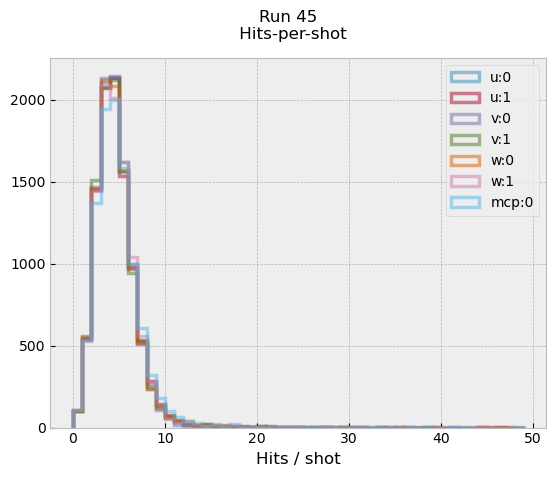

In [64]:
p_hits_per_shot = plt.figure()
for n,cn in det_name.items():
    for c in range(cn+1):
        plt.hist(np.sum(~np.isnan(det_hf[n][c]),axis=1),np.arange(0,50),
                 histtype ='step',label = f'{n}:{c}',
                linewidth=2.5,alpha=0.5);
plt.xlabel('Hits / shot')
plt.legend()
plt.suptitle(f'Run {RUN_NUM} \n Hits-per-shot')



tabs.append(('hits-per-shot',p_hits_per_shot))



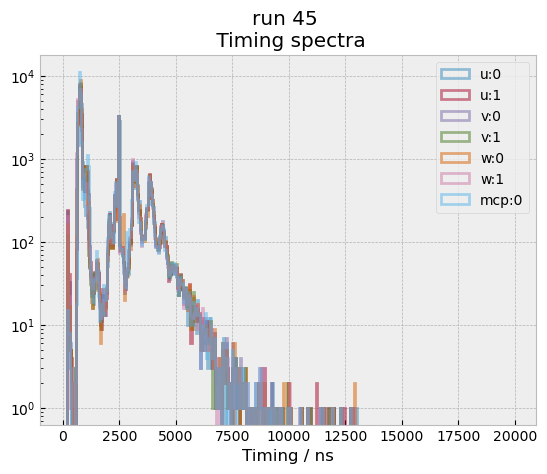

In [70]:

p_timing = plt.figure()
for n,cn in det_name.items():
    for c in range(cn+1):
        plt.hist((np.ndarray.flatten(det_hf[n][c])),
                 bins = np.arange(0,20_000,50),
                 histtype ='step',label = f'{n}:{c}',
                linewidth=2.0,alpha=0.5);
plt.xlabel('Timing / ns')
plt.legend()
plt.yscale('log')
plt.title(f'run {RUN_NUM} \n Timing spectra')
tabs.append(('timing',p_timing))


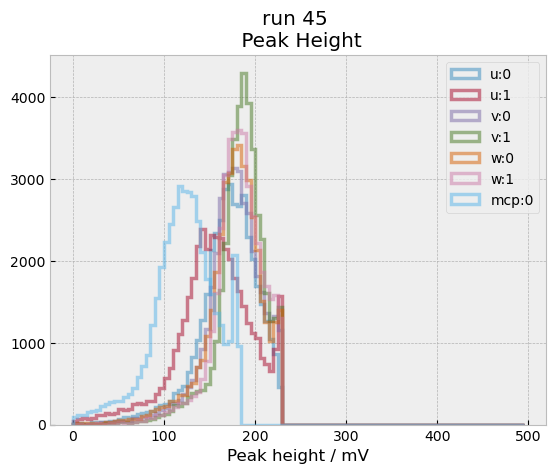

In [78]:

p_height = plt.figure()
for n,cn in det_name.items():
    for c in range(cn+1):
        plt.hist(800/(4095*16)*(np.ndarray.flatten(det_ph[n][c])),
                 np.arange(0,500,5),
                 histtype ='step',label = f'{n}:{c}',
                 linewidth=2.5,alpha=0.5
                );
plt.xlabel('Peak height / mV')
plt.legend()
# plt.yscale('log')
plt.title(f'run {RUN_NUM} \n Peak Height')
tabs.append(('Peak Height',p_height))

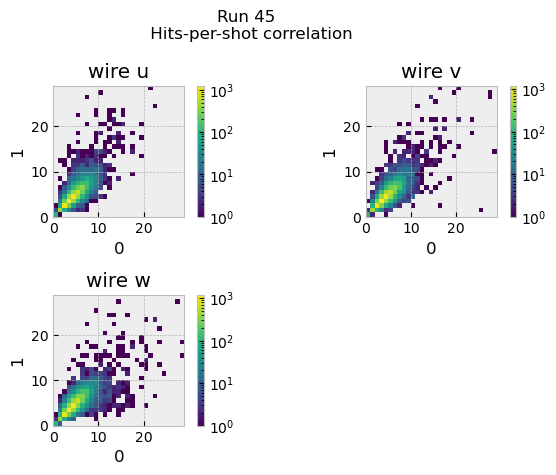

In [79]:
p_hits_per_shot_corr = plt.figure()
for i,n in enumerate(['u','v','w']):
    plt.subplot(2,2,i+1)
    plt.hist2d(np.sum(~np.isnan(det_hf[n][0]),axis=1),
               np.sum(~np.isnan(det_hf[n][1]),axis=1),
               bins = 2*[np.arange(0,30)],norm=colors.LogNorm())
    plt.xlim([0,20])
    plt.ylim([0,20])
    plt.axis('square')
    plt.title('wire '+n)
    plt.xlabel('0')
    plt.ylabel('1')
    plt.colorbar()
plt.suptitle(f'Run {RUN_NUM} \n Hits-per-shot correlation')
plt.tight_layout()
tabs.append(('hits-per-shot correlation',p_hits_per_shot_corr))


In [80]:

v_ts = []
v_td = []

test=0
for q1_n,q2_n,r_n in zip(*det_hf['u'].values(),det_hf['mcp'][0]):

    for q1_i in q1_n[~np.isnan(q1_n)]:
        for q2_i in q2_n[~np.isnan(q2_n)]:
            for r_i in r_n[~np.isnan(r_n)]:
                v_ts.append(q1_i+q2_i-2*r_i)
                v_td.append(q1_i-q2_i)

    test+=1
    if test>1000:
        break



det_ts = {n: [] for n in ['u','v','w']}
det_td = {n: [] for n in ['u','v','w']}


for n in ['u','v','w']:
    for q1_n,q2_n,r_n in zip(*det_hf[n].values(),det_hf['mcp'][0]):
    
        for q1_i in q1_n[~np.isnan(q1_n)]:
            for q2_i in q2_n[~np.isnan(q2_n)]:
                for r_i in r_n[~np.isnan(r_n)]:
                    det_ts[n].append(q1_i+q2_i-2*r_i)
                    det_td[n].append(q1_i-q2_i)
    


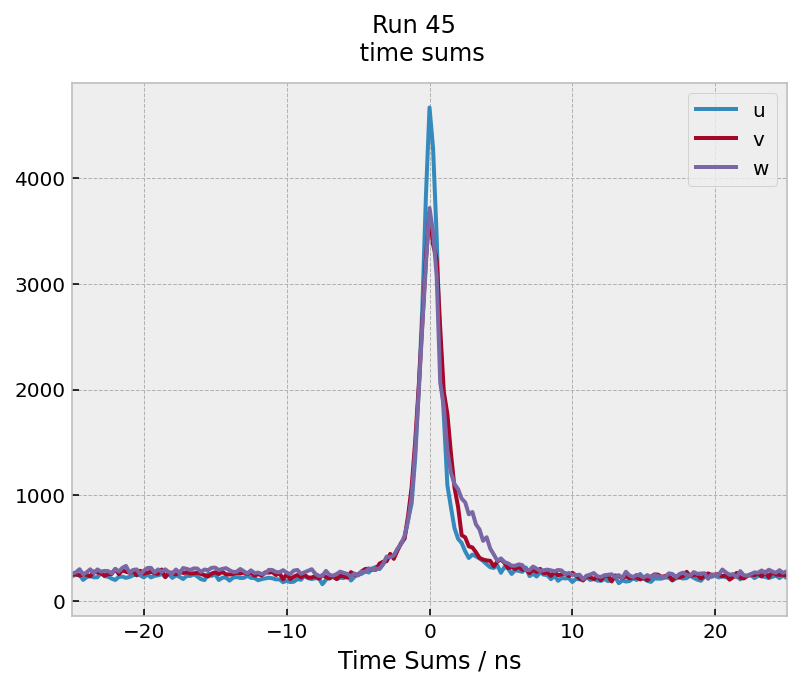

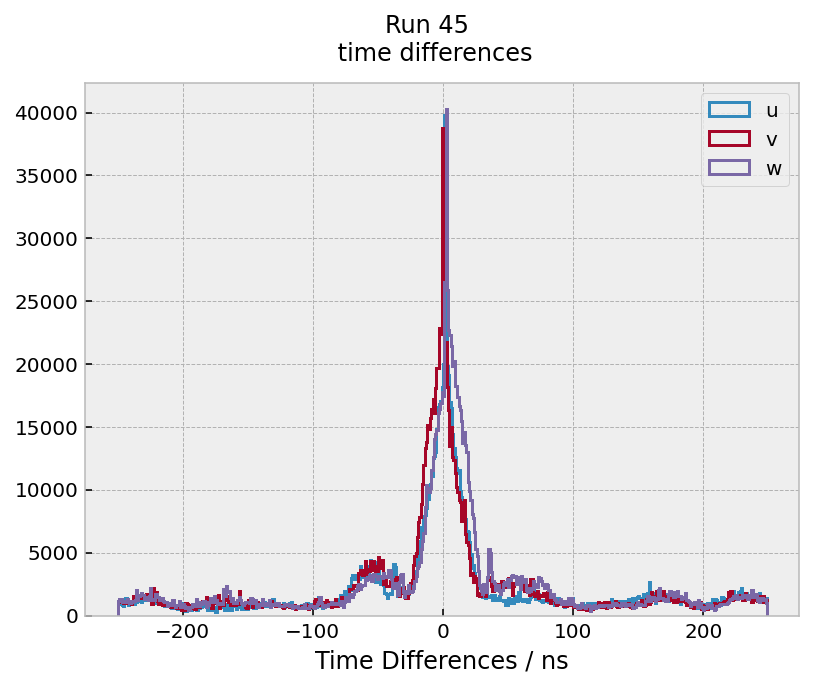

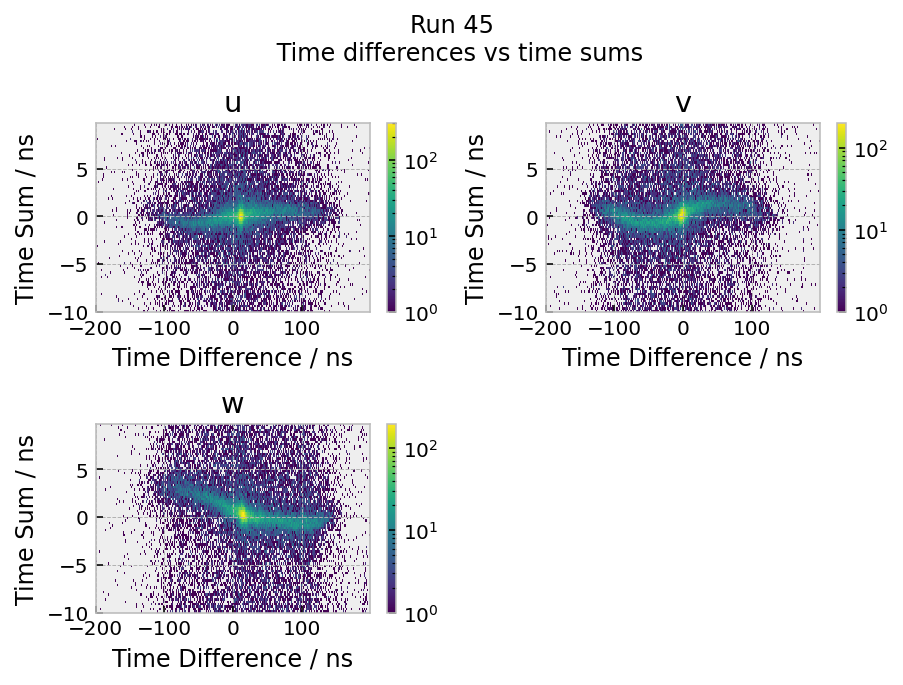

In [83]:

p_time_sums = plt.figure()

ts_edges = np.arange(-100,100,0.25)
ts_bins = 0.5*(ts_edges[:-1]+ts_edges[1:])

for i,n in enumerate(['u','v','w']):
    # plt.subplot(2,2,i+1)
    cnts = np.histogram(np.array(det_ts[n]),ts_edges)[0]
    
    plt.plot(ts_bins-ts_bins[np.argmax(cnts)],
             cnts,
             label = n);
    plt.xlim([-25,25])
    plt.xlabel('Time Sums / ns')
    plt.legend()

plt.suptitle(f'Run {RUN_NUM} \n time sums')
tabs.append(('time-sums',p_time_sums))


p_time_diff = plt.figure()
for n in ['u','v','w']:
    plt.hist(0.168*np.array(det_td[n]),
             np.arange(-250,250,1),
             histtype='step',label = n,
            linewidth=1.5);
plt.xlabel('Time Differences / ns')
plt.legend()

plt.suptitle(f'Run {RUN_NUM} \n time differences')
tabs.append(('time-differences',p_time_diff))



p_time_sum_vs_diff = plt.figure()    
for i,n in enumerate(['u','v','w']):
    
    det_tdn = np.array(det_td[n])
    td_bin = np.arange(-200,200,1)
    
    det_tsn = np.array(det_ts[n])
    ts_bin = np.arange(-10,10,0.25)
    
    cnts = np.argmax(np.histogram(np.array(det_tsn),ts_bins[:-1])[0])

    plt.subplot(2,2,i+1)
    plt.hist2d(det_tdn,det_tsn-ts_bins[cnts],
              [td_bin,ts_bin],
               norm=colors.LogNorm()
              );
    plt.title(n)
    plt.colorbar()
    plt.xlabel('Time Difference / ns')
    plt.ylabel('Time Sum / ns')
plt.suptitle(f'Run {RUN_NUM} \n Time differences vs time sums')
plt.tight_layout()

tabs.append(('time-sums-vs-diff',p_time_sum_vs_diff))

pageTitleFormat = f"hexanode_summary/RUN{RUN_NUM:04d}_hexanode_summary"

prepareHtmlReport(tabs, EXPERIMENT, RUN_NUM, pageTitleFormat)

In [88]:
len(det_td['u'])

1686612